In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [01:09<00:00, 43.1MB/s]
100% 2.70G/2.70G [01:09<00:00, 41.9MB/s]


In [4]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [5]:
train_data='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_data='/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
import os
filtered_classes=[
    folder for folder in os.listdir(train_data)
    if os.path.isdir(os.path.join(train_data,folder)) and "tomato" in folder.lower()
]
print("Filtered Classes:",filtered_classes)

Filtered Classes: ['Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Early_blight']


In [7]:
import tensorflow as tf
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    labels="inferred",
    label_mode="categorical",
    image_size=(150,150),
    batch_size=32,
    class_names=filtered_classes
)

Found 18345 files belonging to 10 classes.


In [8]:
print("Classes in the dataset:",train_dataset.class_names)
class_count=len(train_dataset.class_names)
class_names=train_dataset.class_names

Classes in the dataset: ['Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Early_blight']


In [9]:
validation_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    valid_data,
    labels="inferred",
    label_mode="categorical",
    image_size=(150,150),
    batch_size=32,
    class_names=filtered_classes
)

Found 4585 files belonging to 10 classes.


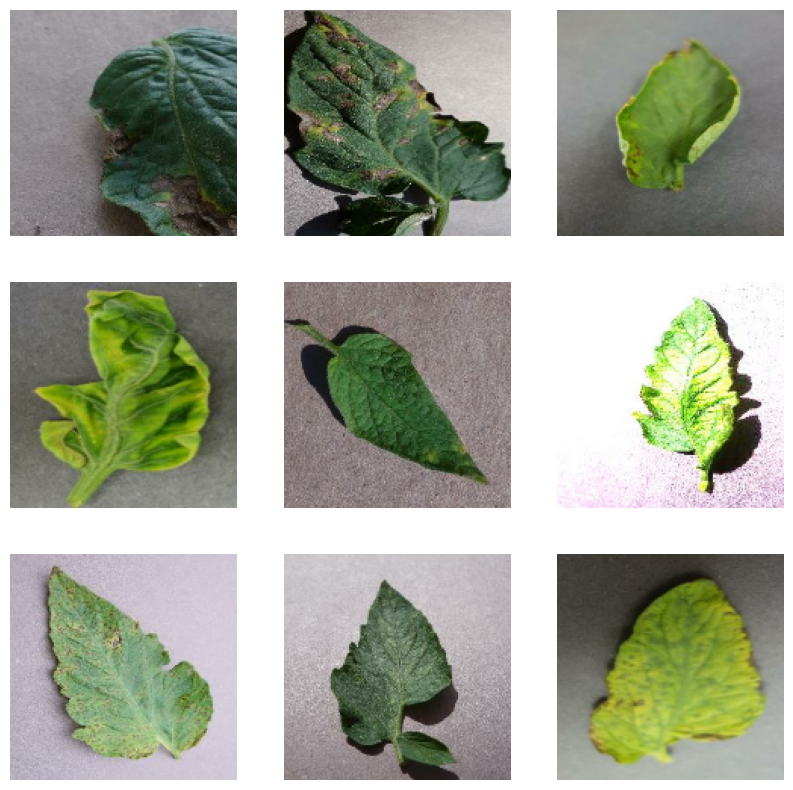

In [10]:
import matplotlib.pyplot as plt
for images,labels in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0/255.0),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [12]:
train_dataset=train_dataset.map(lambda x,y:(data_augmentation(x,training=True),y))

In [13]:
validation_dataset=validation_dataset.map(lambda x,y:(tf.keras.layers.Rescaling(1.0/255.0)(x),y))

In [14]:
vggmodel=tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(150,150,3),
    weights="imagenet"
)
for layers in vggmodel.layers:
  layers.trainable=False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
vggmodel.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
for layer in vggmodel.layers[-8:]:  #5TH Block of VGG16 for training
  layer.trainable=True

In [17]:
vggmodel.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 14,158,848 (54.01 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling3D,BatchNormalization
model=Sequential()
model.add(vggmodel)
model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(class_count,activation='softmax'))

In [19]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
early_stoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [21]:
history=model.fit(train_dataset,validation_data=validation_dataset,epochs=15,callbacks=early_stoping)

Epoch 1/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 228s 361ms/step - accuracy: 0.1231 - loss: 3.9947 - val_accuracy: 0.4055 - val_loss: 2.4394
Epoch 2/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 237s 345ms/step - accuracy: 0.2383 - loss: 3.2798 - val_accuracy: 0.5413 - val_loss: 2.0537
Epoch 3/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 204s 348ms/step - accuracy: 0.3322 - loss: 2.8248 - val_accuracy: 0.5839 - val_loss: 1.9199
Epoch 4/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 197s 342ms/step - accuracy: 0.4062 - loss: 2.4856 - val_accuracy: 0.6336 - val_loss: 1.8254
Epoch 5/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 194s 338ms/step - accuracy: 0.4775 - loss: 2.2388 - val_accuracy: 0.5675 - val_loss: 2.0385
Epoch 6/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 202s 339ms/step - accuracy: 0.5455 - loss: 2.0369 - val_accuracy: 0.6465 - val_loss: 1.8447
Epoch 7/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 194s 338ms/step - accuracy: 0.6067 - loss: 1.8483 - val_accuracy: 0.6953 - val_loss: 1.6100
Epoch 8/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 206s 344ms/step - accuracy: 0.6450 -

In [22]:
evaluation=model.evaluate(validation_dataset)
print("Validation Loss:",evaluation[0])
print("Validation Accuracy:",evaluation[1])

144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8597 - loss: 1.0602
Validation Loss: 1.068366527557373
Validation Accuracy: 0.8525627255439758


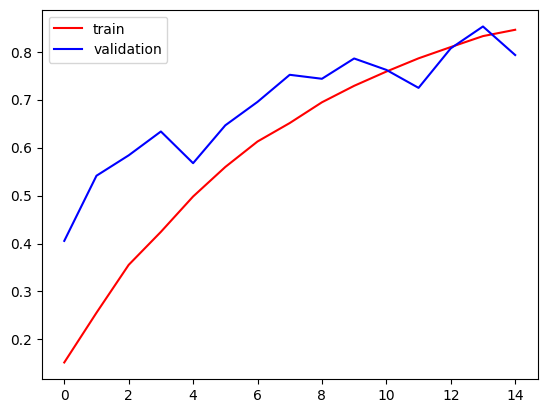

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

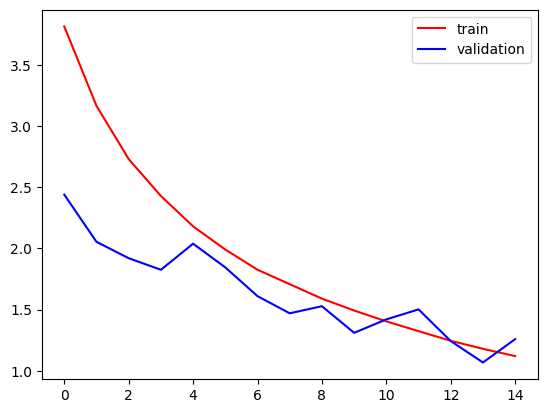

In [24]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [25]:
!ls /content/test/test

AppleCedarRust1.JPG  CornCommonRust3.JPG     TomatoEarlyBlight2.JPG  TomatoYellowCurlVirus1.JPG
AppleCedarRust2.JPG  PotatoEarlyBlight1.JPG  TomatoEarlyBlight3.JPG  TomatoYellowCurlVirus2.JPG
AppleCedarRust3.JPG  PotatoEarlyBlight2.JPG  TomatoEarlyBlight4.JPG  TomatoYellowCurlVirus3.JPG
AppleCedarRust4.JPG  PotatoEarlyBlight3.JPG  TomatoEarlyBlight5.JPG  TomatoYellowCurlVirus4.JPG
AppleScab1.JPG	     PotatoEarlyBlight4.JPG  TomatoEarlyBlight6.JPG  TomatoYellowCurlVirus5.JPG
AppleScab2.JPG	     PotatoEarlyBlight5.JPG  TomatoHealthy1.JPG      TomatoYellowCurlVirus6.JPG
AppleScab3.JPG	     PotatoHealthy1.JPG      TomatoHealthy2.JPG
CornCommonRust1.JPG  PotatoHealthy2.JPG      TomatoHealthy3.JPG
CornCommonRust2.JPG  TomatoEarlyBlight1.JPG  TomatoHealthy4.JPG


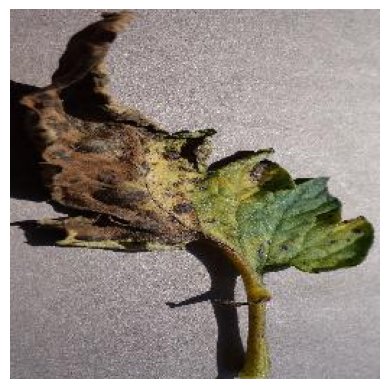

In [26]:
import matplotlib.pyplot as plt
img_path='/content/test/test/TomatoEarlyBlight1.JPG'
img=plt.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()


In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/test/test/TomatoEarlyBlight1.JPG'

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img)

img_array /= 255.0

img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

predicted_class_label = class_names[predicted_class_index]

print("Predicted Class:", predicted_class_label)
print("Predicted Class Probability:", predictions[0][predicted_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Tomato___Late_blight
Predicted Class Probability: 0.43470863
